# Model-based vs Model-free

In the scope of RL, model refers to the envrionment model that interact with the agent. Based on whether there exists a environment model, RL can be divided into 2 categories: model-based RL and model-free RL. In model-free RL, agents conduct policy improvement or value estimation directly based on sampled data gathered from the interaction with the environment. The algorithms we introduced in chapter 5, Sarsa and Q-lreaning, belong to model-free RL. 

In model-based RL, the environment could be known before training, or it could be learnt from the interaction. The envrionemnt model will then be used to enhance the value estimation or policy improvement. The 2 methods we discussed in chapter 4, policy iteration and value iteration, are model-based algorithms, in which setting the environment model is known. Dyna-Q, which we will introduce in this chapter, is another typical model-absed algorithm whose model is learnt from the interaction.

Usually, we can evaluate an RL algorithm with 2 metrics, the expected return starting from inital states after convergence, and sample complexity, namely the number of samples required to reach convergence. Model-based methods, as the agents can interact with the environment model rather than the real environment, usually has a smaller sample complexity than that of model-free methods. However, the environment model may not be accurate. Hence, model-based methods could have lower expected return after convergence.

# Dyna-Q algorithm

Dyna-Q adopts a Q-planning method to generate several simulated data, and use the simulated data together with real data samples to improve the policy. Q-planning takes a previous visited state $s$ and an action $a$ which was taken under state $s$, based on the environment model to get $r$ and $s'$, and then update $Q$ based on $(s, a, r, s')$ via Q-learning ($Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma \max_{a'} Q(s', a')-Q(s, a))$).

The full process is given below:
- Init Q(s, a), M(s, a)
- for episode $e \leftarrow 1$ to $E$:
    - get start state $s$
    - for timestep $s \leftarrow 1$ to $T$:
        - get action $a$ via $\epsilon$-greedy
        - get $r, s'$ from the real environment
        - $Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma \max_{a'} Q(s', a')-Q(s, a))$ # update action values
        - $M(s, a) \leftarrow r, s'$ # update env model
        - for $n \leftarrow 1$ to $N$:
            - randomly access a visited state $s_m$
            - randomly select a previous taken action $a_m$ under $s_m$
            - $r_m, s'_m \leftarrow M(s_m, a_m)$ 
            - $Q(s_m, a_m) \leftarrow Q(s_m, a_m) + \alpha (r_m + \gamma \max_{a'} Q(s'_m, a')-Q(s_m, a_m))$
        - end for
        - $s' \leftarrow s$
    - end for
- end for

Dyna-Q do $N$ Q-planning after 1 Q-learning, where $N$ is a tunable hyperparameter and when $N=0$ Dyna-Q degrades to Q-learning. Notice that the model in the algorithm above is only suitable for a deterministic descrete envrionment. You may what to change how the model models the environment to better fit different occasions.

Now let's implement Dyna-Q in cliff walk.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [27]:
class DynaQ:
    """ DynaQ算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4, n_planning=10):
        self.Q_table = np.random.random([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
        self.n_planning = n_planning
        self.M = dict()
        self.taken = dict()

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
       # TODO: finish the epsilon-greedy action chosen
        rand = np.random.random()
        if rand > self.epsilon:
            action = np.argmax(self.Q_table[state])
        else:
            action = np.random.choice(range(self.n_action))
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def qlearning(self, s0, a0, r, s1):
        self.Q_table[s0, a0] += self.alpha *(r + self.gamma * np.max(self.Q_table[s1]) - self.Q_table[s0, a0])

    def update(self, s0, a0, r, s1):
        # TODO: q-learning and q-planning
        # q-learning
        self.qlearning(s0, a0, r, s1)
        # record into model
        self.M[(s0, a0)] = (r, s1)
        if s0 not in self.taken:
            self.taken[s0] = [a0]
        else:
            self.taken[s0].append(a0)

        # q-planning
        for i in range(self.n_planning):
            sm = np.random.choice(list(self.taken.keys()))
            am = np.random.choice(self.taken[sm])
            rm, s_prime_m = self.M[(sm, am)]
            self.qlearning(sm, am, rm, s_prime_m)


In the following, we encapsule 

In [28]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    n_action = 4
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_action, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少条序列

    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 11101.92it/s, episode=300, return=-16.700]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1784.73it/s, episode=300, return=-13.000]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 263.18it/s, episode=300, return=-13.000]


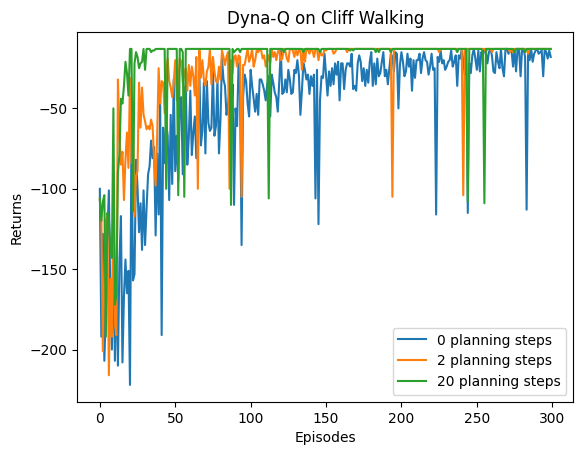

In [29]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()

It is easy to observe that with the increment of planning steps, the algorithm converges more and more quickly. However, the environment here is simple and deterministic, which is easy to learn for the environment model. If the environment is complex, or the states are continuous, or the environment is not deterministic, then learning an accurate model can be a great challange, which strongly affects if model-based RL can do better.